In [1]:
# ================================================================================ #
# =========================== Goolge Colab File Upload =========================== #
# ================================================================================ #

from google.colab import drive
drive.mount('/content/drive')

# 출력값 초기화
from google.colab import output
output.clear()

# 경로 수정
import os
os.chdir("drive/MyDrive/Colab Notebooks/가스공급량 수요예측 모델개발")

# method 2. local repository
# 따로 할 거 없음..

In [2]:
# import libary
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import os, glob, sys
import matplotlib.pyplot as plt

train_csv = pd.read_csv("./datasets/한국가스공사_시간별 공급량.csv", encoding = 'cp949', engine='python')

# test_csv 파일 전처리
test_csv = pd.read_csv("./datasets/test.csv", encoding = 'utf-8')

test_date = []
test_hour = []
test_class = []

for component in test_csv.values:
    string = component.item()
    test_date.append(string.split(" ")[0])
    test_hour.append(string.split(" ")[1])
    test_class.append(string.split(" ")[-1])

test_csv = pd.DataFrame({'연월일':test_date, "시간":test_hour, "구분":test_class})
sample_submission = pd.read_csv("./datasets/sample_submission.csv", encoding = "utf-8")

In [3]:
# rename column
train_csv.rename(columns = {'연월일' : 'time', "시간":"hour", "구분":"class", "공급량":"power"}, inplace = True)

In [4]:
# rename column
test_csv.rename(columns = {'연월일' : 'time', "시간":"hour", "구분":"class"}, inplace = True)

In [5]:
# 자료형 변환
from datetime import datetime

# time : str to datetime
try:
    train_csv["time"] = train_csv["time"].apply(lambda x : datetime.strptime(x, "%Y-%m-%d"))
    test_csv["time"] = test_csv["time"].apply(lambda x : datetime.strptime(x, "%Y-%m-%d"))
except:
    print("data type of time not str or already converted")

# hour : str to int

try:
    test_csv["hour"] = test_csv["hour"].apply(lambda x : int(x))
except:
    print("data type of hour not str or already converted")

In [6]:
# time - hour => timestamp with yyyy-mm-dd-hh
import datetime

def df_time_convert(df):
    df_copy = df.copy(...)
    timestamp_list = []
    for idx in range(len(df)):
        timestamp_list.append(df_copy.time.iloc[idx] + datetime.timedelta(hours = df_copy.hour.iloc[idx].item()))
    df_copy["time"] = timestamp_list
    return df_copy

# class에 따른 데이터프레임 분류
def df_class_split(df, cls = "A"):
    df_copy = df.copy(...)
    df_copy = df_copy[df_copy["class"] == cls]
    return df_copy

# class to idx
def class_to_idx(x):
    dic = {'A':0,"B":1,"C":2,"D":3,'E':4,'G':5,"H":6}
    if type(x) == str:
        try:
            return_value = int(dic[x])
        except:
            return_value = 0
            print("didn't find class {}".format(x))

    else:
        return_value = 0
    
    return return_value

In [7]:
import matplotlib.pyplot as plt
from datetime import timedelta

def plot_time_series_data(df, xl = None, xr = None, figsize = (16,8), col = "power", label = "power", c = "b", fig_num = 1):

    x_axis = df.time
    y_axis = df[col]

    if xl is None and xr is None:
        pass
    elif xl is not None and xr is None:
        x_axis = x_axis[xl:]
        y_axis = y_axis[xl:]
    elif xl is None and xr is not None:
        x_axis = x_axis[:xr]
        y_axis = y_axis[:xr]
    else:
        x_axis = x_axis[xl:xr]
        y_axis = y_axis[xl:xr]

    plt.figure(fig_num, figsize = figsize)
    plt.plot(x_axis, y_axis, label = label, c = c)
    plt.xlabel("time")
    plt.ylabel("power")
    plt.legend()
    plt.show()

In [8]:
# External Data(weather)
import glob2
import datetime

path_list_external_weather = glob2.glob("./dataset_external_weather/*")
print(path_list_external_weather)

df_weather = None
for idx, path in enumerate(path_list_external_weather):

    if idx == 0:
        df_weather = pd.read_csv(path, encoding = "cp949")
    else:
        df_temp = pd.read_csv(path, encoding = "cp949")
        df_weather = pd.concat([df_weather, df_temp], axis = 0)

display(df_weather)

# column name change
df_weather.rename(columns = {"일시": "date_time","기온(°C)" : "temperature", "습도(%)":"humidity", "증기압(hPa)" : "vapor", "현지기압(hPa)":"pressure", "풍속(m/s)":"wind_speed"}, inplace = True)

df_weather["date_time"] = df_weather["date_time"].apply(lambda x : datetime.datetime.strptime(x,"%Y-%m-%d %H:%M" ))

# 결측치 보완
df_weather["temperature"] = df_weather["temperature"].interpolate(method = "values")
df_weather["humidity"] = df_weather["humidity"].interpolate(method = "values")
df_weather["vapor"] = df_weather["vapor"].interpolate(method = "values")
df_weather["wind_speed"] = df_weather["wind_speed"].interpolate(method = "values")
df_weather["pressure"] = df_weather["pressure"].interpolate(method = "values")

# merge
df = train_csv.copy()
df = df_time_convert(df)
df["class"] = df["class"].apply(lambda x : class_to_idx(x))

df_merge = pd.merge(left = df, right = df_weather[["date_time", "temperature", "humidity", "vapor", "pressure", "wind_speed"]], how = 'outer', left_on = "time", right_on = "date_time")
df_merge = df_merge.drop(columns = ['date_time'], axis = 1)
display(df_merge)

['./dataset_external_weather/OBS_ASOS_TIM_20211017003024.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017003117.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017004006.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017004047.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017004154.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017004224.csv']


,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),증기압(hPa),이슬점온도(°C),현지기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),운형(운형약어),지면온도(°C)
0,108,서울,2013-01-01 01:00,-8.5,NaN,4.0,50.0,57.0,1.8,-15.5,1010.0,NaN,NaN,6.4,NaN,NaN,-3.4
1,108,서울,2013-01-01 02:00,-8.4,NaN,4.0,70.0,60.0,2.0,-14.7,1009.4,NaN,NaN,6.4,NaN,NaN,-3.4
2,108,서울,2013-01-01 03:00,-8.1,NaN,3.4,70.0,58.0,1.9,-14.9,1009.2,NaN,NaN,6.4,6.0,Ac,-3.4
3,108,서울,2013-01-01 04:00,-8.2,NaN,3.8,70.0,58.0,1.9,-15.0,1008.2,NaN,NaN,6.4,6.0,Ac,-3.4
4,108,서울,2013-01-01 05:00,-8.2,NaN,4.4,70.0,61.0,2.0,-14.4,1007.3,NaN,NaN,6.4,10.0,ScAs,-3.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,108,서울,2018-12-31 21:00,-4.6,NaN,1.1,290.0,44.0,1.9,-15.0,1024.8,NaN,NaN,NaN,0.0,NaN,-4.1
8756,108,서울,2018-12-31 22:00,-5.4,NaN,1.3,270.0,46.0,1.9,-15.2,1024.4,NaN,NaN,NaN,0.0,NaN,-5.0
8757,108,서울,2018-12-31 23:00,-5.2,NaN,1.6,320.0,47.0,2.0,-14.7,1024.6,NaN,NaN,NaN,0.0,NaN,-5.1
8758,108,서울,2019-01-01 00:00,-5.5,NaN,1.0,290.0,54.0,2.2,-13.3,1024.1,NaN,NaN,NaN,0.0,NaN,-6.0


,time,hour,class,power,temperature,humidity,vapor,pressure,wind_speed
0,2013-01-01 01:00:00,1.0,0.0,2497.129,-8.5,57.0,1.8,1010.0,4.0
1,2013-01-01 01:00:00,1.0,1.0,2169.093,-8.5,57.0,1.8,1010.0,4.0
2,2013-01-01 01:00:00,1.0,2.0,226.178,-8.5,57.0,1.8,1010.0,4.0
3,2013-01-01 01:00:00,1.0,3.0,1434.516,-8.5,57.0,1.8,1010.0,4.0
4,2013-01-01 01:00:00,1.0,4.0,3272.837,-8.5,57.0,1.8,1010.0,4.0
...,...,...,...,...,...,...,...,...,...
368084,2019-01-01 00:00:00,24.0,3.0,1422.478,-5.5,54.0,2.2,1024.1,1.0
368085,2019-01-01 00:00:00,24.0,4.0,3534.260,-5.5,54.0,2.2,1024.1,1.0
368086,2019-01-01 00:00:00,24.0,5.0,3982.757,-5.5,54.0,2.2,1024.1,1.0
368087,2019-01-01 00:00:00,24.0,6.0,560.896,-5.5,54.0,2.2,1024.1,1.0


In [9]:
df_merge = df_merge.dropna()

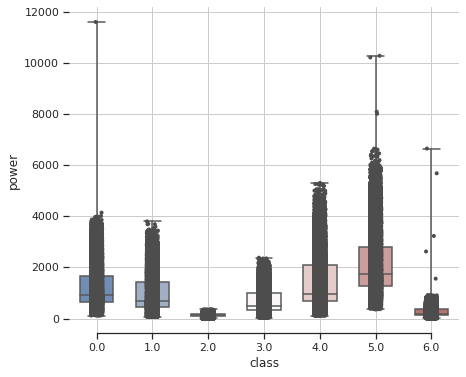

In [10]:
# anomality annhiliation
# statistics
class_list = np.unique(train_csv["class"].values).tolist()

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))

# Plot the orbital period with horizontal boxes
sns.boxplot(x="class", y="power", data=df_merge, whis=[0, 100], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x="class", y="power", data=df_merge, size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.yaxis.grid(True)
ax.set(ylabel="power")
sns.despine(trim=True, left=True)

In [24]:
df_list[0].keys()

Index(['time', 'hour', 'class', 'power', 'temperature', 'humidity', 'vapor',
       'pressure', 'wind_speed'],
      dtype='object')

In [29]:
# Correlation Analysis
# class 별로 데이터 구분
class_letters = ['A','B','C','D','E','G','H']
df_list = [df_class_split(df_merge, cls = i).sort_values(by = ["time"]) for i in range(len(class_letters))]

# 기상값과 상관관계를 모두 비교
cols_for_corr = list(df_list[0].keys())
cols_for_corr.remove("power")
cols_for_corr.remove("time")
cols_for_corr.remove("hour")
cols_for_corr.remove("class")

for col in cols_for_corr:
    print("===================================================================")
    for cls, df in zip(class_letters, df_list):
        corr = df[[col, "power"]].corr()[col][1]
        print("# class : {} and correlation btn power and {} : {:.3f}".format(cls, col, corr))

# class : A and correlation btn power and temperature : -0.826
# class : B and correlation btn power and temperature : -0.846
# class : C and correlation btn power and temperature : -0.775
# class : D and correlation btn power and temperature : -0.864
# class : E and correlation btn power and temperature : -0.865
# class : G and correlation btn power and temperature : -0.822
# class : H and correlation btn power and temperature : -0.830
# class : A and correlation btn power and humidity : -0.293
# class : B and correlation btn power and humidity : -0.277
# class : C and correlation btn power and humidity : -0.226
# class : D and correlation btn power and humidity : -0.278
# class : E and correlation btn power and humidity : -0.271
# class : G and correlation btn power and humidity : -0.314
# class : H and correlation btn power and humidity : -0.272
# class : A and correlation btn power and vapor : -0.701
# class : B and correlation btn power and vapor : -0.714
# class : C and correlati

In [27]:
# 기상값 사이의 상관계수도 분석
weather_cols = ['temperature', 'humidity', 'vapor', 'pressure', 'wind_speed']
corrs = df_merge[weather_cols].corr()
print(corrs)

             temperature  humidity     vapor  pressure  wind_speed
temperature     1.000000  0.149872  0.846913 -0.750345    0.015113
humidity        0.149872  1.000000  0.523473 -0.340715   -0.213243
vapor           0.846913  0.523473  1.000000 -0.748915   -0.068971
pressure       -0.750345 -0.340715 -0.748915  1.000000   -0.131225
wind_speed      0.015113 -0.213243 -0.068971 -0.131225    1.000000


In [30]:
# 각 class 별 데이터 크기 및 일자 확인
idx_to_class = ['A', 'B','C', 'D', "E", 'G', 'H']
for idx, df in enumerate(df_list):
    print("class : {}, length : {}, start time : {}, end time : {}".format(
        idx_to_class[idx],
        len(df),
        df['time'].iloc[0],
        df['time'].iloc[-1]
    ))

class : A, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : B, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : C, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : D, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : E, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : G, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : H, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00


In [31]:
# 이상치 제거
def remove_outlier(df_input, column):
    df = df_input.copy(...)
    df_removed_column_outlier = df[column]
    quan_25 = np.percentile(df_removed_column_outlier.values, 25)
    quan_75 = np.percentile(df_removed_column_outlier.values, 75)

    iqr = quan_75 - quan_25
    iqr = iqr * 1.5

    lowest = quan_25 - iqr
    highest = quan_75 + iqr

    outlier_index = df_removed_column_outlier[(df_removed_column_outlier < lowest) | (df_removed_column_outlier > highest)].index
    
    if len(outlier_index) > 0:
        print("# outlier detected")
        df.drop(outlier_index, axis = 0, inplace = True)
    else:
        print("# outlier not detected")
        pass

    return df

df_list_new = []
for df in df_list:
    df = remove_outlier(df, "power")
    df_list_new.append(df)

df_list = df_list_new

idx_to_class = ['A', 'B','C', 'D', "E", 'G', 'H']
for idx, df in enumerate(df_list):
    print("class : {}, length : {}, start time : {}, end time : {}".format(
        idx_to_class[idx],
        len(df),
        df['time'].iloc[0],
        df['time'].iloc[-1]
    ))

# outlier detected
# outlier detected
# outlier detected
# outlier detected
# outlier detected
# outlier detected
# outlier detected
class : A, length : 52231, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : B, length : 52300, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : C, length : 52308, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : D, length : 52439, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : E, length : 52332, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : G, length : 52214, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : H, length : 52352, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00


In [ ]:
# 0인 이상치도 제거...
df_list_new = []
for df in df_list:
    index_list = df["power"].values >= 10
    df = df.iloc[index_list]
    df_list_new.append(df)

df_list = df_list_new

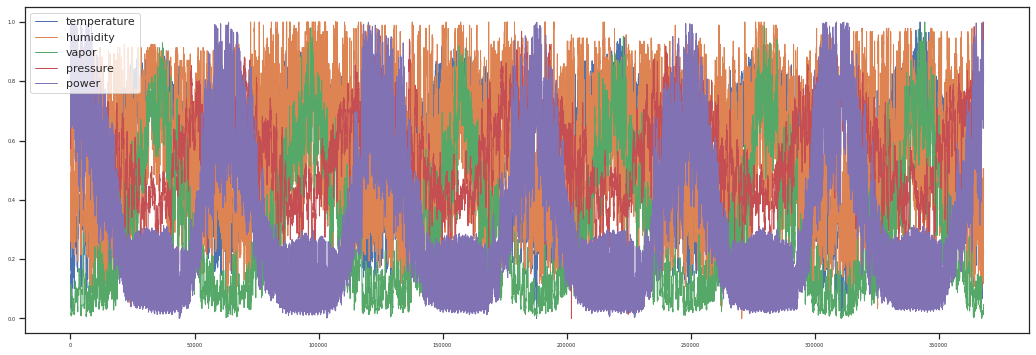

In [58]:
# 정상성 / 계절성 요소 파악 : temperature, humidity, vapor, pressure, power
# adf-test를 이용
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

adf_cols = ['temperature', 'humidity', "vapor", "pressure", 'power']
df_adf_test = pd.DataFrame(scaler.fit_transform(df_list[0][adf_cols].values), columns=adf_cols, index=df_list[0].index)
df_adf_test.plot(figsize=(18,6), linewidth=1, fontsize = 5)

In [59]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df, col):
    result = adfuller(df[col].values)
    print("=============================")
    print("variable : {}".format(col))
    print("ADF statistics :%f"%result[0])
    print("ADF p-value : %f"%result[1])
    print("Critical Values : ")
    for key, value in result[4].items():
        print("\t%s : %.3f"%(key, value))
    print("=============================")

adf_test(df_adf_test, "power")
adf_test(df_adf_test, "temperature")
adf_test(df_adf_test, "humidity")
adf_test(df_adf_test, "vapor")
adf_test(df_adf_test, "pressure")

variable : power
ADF statistics :-4.958430
ADF p-value : 0.000027
Critical Values : 
	1% : -3.430
	5% : -2.862
	10% : -2.567
variable : temperature
ADF statistics :-5.256264
ADF p-value : 0.000007
Critical Values : 
	1% : -3.430
	5% : -2.862
	10% : -2.567
variable : humidity
ADF statistics :-19.984972
ADF p-value : 0.000000
Critical Values : 
	1% : -3.430
	5% : -2.862
	10% : -2.567
variable : vapor
ADF statistics :-5.706115
ADF p-value : 0.000001
Critical Values : 
	1% : -3.430
	5% : -2.862
	10% : -2.567
variable : pressure
ADF statistics :-9.498942
ADF p-value : 0.000000
Critical Values : 
	1% : -3.430
	5% : -2.862
	10% : -2.567
